In [ ]:
# !unzip -qq 'MNIST_9-25.zip'

In [11]:
# %pip install threadpoolctl==3.1.0
# % pip install python_speech_features
# % pip install pydub
# % pip install hmmlearn
# % pip install librossa

In [42]:
import threadpoolctl
import numpy as np
from scipy.io import wavfile
from pydub import AudioSegment
import warnings
from python_speech_features import mfcc, logfbank

In [35]:
import os

def build_one_model_tmp(input_folder, num_states, num_cep_coeff):
    # input_folder: path to the folder containing training wav files with the word
    # num_states: number of hidden states in HMM
    # num_cep_coeff: number of MFCC features extracted from each time window
    training_files = [x for x in os.listdir(input_folder) if x.endswith('.wav')]
    file_num = 0
    for filename in training_files:
        file_num += 1
        # Extract the current filepath and read the file
        filepath = os.path.join(input_folder, filename)
        print(filename)
        if file_num == 5:
            return
    return

input_folder = "./MNIST_9-25"
num_components = 15
num_cepstr = 30
for dirname in os.listdir(input_folder):
    # Get name of subfolder
    subfolder = os.path.join(input_folder, dirname)
    print("folder=",subfolder)
    if not os.path.isdir(subfolder):
        continue

        # Extract label
    label = subfolder[subfolder.rfind('/') + 1:]
    build_one_model_tmp(subfolder, num_states=num_components, num_cep_coeff=num_cepstr)

folder= ./MNIST_9-25/num2
20_phone_2.wav
6_phone_2.wav
50_phone_2.wav
83_phone_2.wav
62_phone_2.wav
folder= ./MNIST_9-25/num5
93_phone_5.wav
109_phone_5.wav
30_phone_5.wav
40_phone_5.wav
72_phone_5.wav
folder= ./MNIST_9-25/num4
72_phone_4.wav
40_phone_4.wav
30_phone_4.wav
93_phone_4.wav
86_phone_4.wav
folder= ./MNIST_9-25/num3
12_phone_3.wav
105_phone_3.wav
62_phone_3.wav
83_phone_3.wav
50_phone_3.wav
folder= ./MNIST_9-25/num8
75_phone_8.wav
88_phone_8.wav
47_phone_8.wav
37_phone_8.wav
94_phone_8.wav
folder= ./MNIST_9-25/num6
67_phone_6.wav
17_phone_6.wav
49_phone_6.wav
39_phone_6.wav
25_phone_6.wav
folder= ./MNIST_9-25/num1
59_phone_1.wav
29_phone_1.wav
77_phone_1.wav
96_phone_1.wav
35_phone_1.wav
folder= ./MNIST_9-25/num0
45_phone_0.wav
35_phone_0.wav
29_phone_0.wav
59_phone_0.wav
12_phone_0.wav
folder= ./MNIST_9-25/num7
86_phone_7.wav
55_phone_7.wav
3_phone_7.wav
25_phone_7.wav
39_phone_7.wav
folder= ./MNIST_9-25/num9
19_phone_9.wav
69_phone_9.wav
94_phone_9.wav
37_phone_9.wav
47_ph

In [36]:
# %pip install hmmlearn

In [37]:
from hmmlearn import hmm
class ModelHMM(object):
    def __init__(self, num_components=8, num_iter=1000):
        self.n_components = num_components
        self.n_iter = num_iter
    # Define the covariance type and the type of HMM:
        self.cov_type = 'diag'
        self.model_name = 'GaussianHMM'
    # Initialize the variable in which we will store the models for each word:
        self.models = []
    # Define the model using the specified parameters:
        self.model = hmm.GaussianHMM(n_components=self.n_components,
                covariance_type=self.cov_type,n_iter=self.n_iter)

    # Define a method to train the model
    # 'training_data' is a 2D numpy array where each row has length of number of mfcc coefficients
    def train(self, training_data):
        np.seterr(all='ignore')
        cur_model = self.model.fit(training_data)
        self.models.append(cur_model)

    # Define a method to compute log likelihood score for input features
    def compute_score(self, input_data):
        return self.model.score(input_data)  # model.score returns log likelihood of sample input_data

In [38]:
def build_one_model(input_folder, num_states, num_cep_coeff):
    # input_folder: path to the folder containing training wav files with the word
    # num_states: number of hidden states in HMM
    # num_cep_coeff: number of MFCC features extracted from each time window
    X = np.array([])  # features
    training_files = [x for x in os.listdir(input_folder) if x.endswith('.wav')]
    for filename in training_files:
        # Extract the current filepath and read the file
        filepath = os.path.join(input_folder, filename)
        sampling_freq, signal = wavfile.read(filepath)
        sound = AudioSegment.from_file(filepath, format="wav")
        duration = len(sound)
        
        if duration < 150: # ПРОПУСК КОРОТКИХ СИГНАЛОВ
            continue

        start_trim = detect_leading_silence(sound)
        end_trim = detect_leading_silence(sound.reverse())
        duration = len(sound)
        trimmed_sound = sound[start_trim:duration - end_trim]
        trimmed_sound.export("tmp.wav", format="wav")
        # Extract features
        # Default values:
        # winlen=0.025, winstep=0.01, nfft=512,
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            features_mfcc = mfcc(signal, sampling_freq, numcep=num_cep_coeff)

        # Append features to the variable X
        if len(X) == 0:
            X = features_mfcc
        else:
            X = np.append(X, features_mfcc, axis=0)

    # Initiate HMM model object
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        model = ModelHMM(num_components=num_states)

    # Train HMM model, calculate likelihood of the sample by the trained model
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        model.train(X)
        model_score = model.compute_score(X)

    return model, model_score, num_cep_coeff

In [39]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [40]:
def build_models(input_folder):

    # input_folder contains subfolders with samples of words in wav files

    # Initialize the variable to store all the models
    speech_models = []

    # Parse the input directory
    for dirname in os.listdir(input_folder):

        # Get name of subfolder
        subfolder = os.path.join(input_folder, dirname)

        if not os.path.isdir(subfolder):
            continue

        # Extract label
        label = subfolder[subfolder.rfind('/') + 1:]

        # Fit model for label
        model = build_one_model(subfolder, num_states=num_components, num_cep_coeff=num_cepstr)

        # Add the model to the list
        speech_models.append((model, label))

        # Reset model variable
        model = None
        print("Fitted "+dirname)
    return speech_models

In [43]:
digit_models = build_models('MNIST_9-25')

Fitted num2
Fitted num5
Fitted num4
Fitted num3
Fitted num8
Fitted num6
Fitted num1
Fitted num0
Fitted num7
Fitted num9


In [349]:
import joblib
joblib.dump(digit_models,'saved.pkl')

In [350]:
speech_models = joblib.load('saved.pkl')

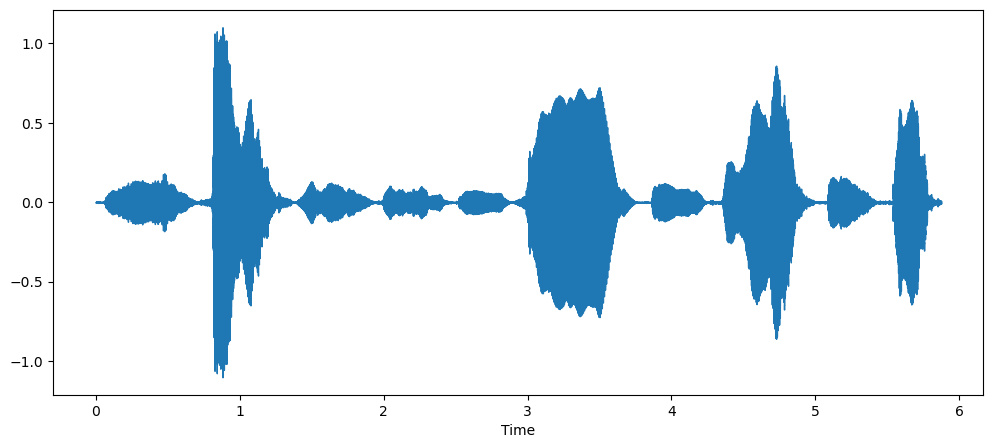

Signal rate=  22050


In [352]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
wavfile = "./test/0/0.wav"
#data, rate = sf.read(wavfile, dtype='float32')
x, sr = librosa.load(wavfile)
# Plot the sample.
plt.figure(figsize=(12, 5))
librosa.display.waveshow(x, sr=sr)
plt.show()
print("Signal rate= ",sr)

In [355]:
from pydub import AudioSegment
from pydub.silence import split_on_silence
sound_file = AudioSegment.from_wav(wavfile)
silence_len = 100   
thresh = -40
audio_chunks = split_on_silence(sound_file, min_silence_len=silence_len, silence_thresh=thresh)
num_signals = len(audio_chunks)
print(num_signals)

10


In [356]:
def split_on_ten(sound_file, min_silence_len=150, silence_thresh=-40, step=30):
    silence_len = min_silence_len
    while silence_len > 0:
        audio_chunks = split_on_silence(sound_file, min_silence_len=silence_len, silence_thresh=thresh)
        num_signals = len(audio_chunks)
        if num_signals == 10:
            return audio_chunks
        silence_len -= step
    raise 1
        

In [357]:
audio_chunks = split_on_ten(sound_file)
num_signals = len(audio_chunks)
print(num_signals)

10


In [358]:
def score_one_word(trained_model, test_file_path):
    # trained_model: ModelHMM object with trained model
    # test_file_path: path to wav file

    sampling_freq, signal = wavfile.read(test_file_path)
    num_cep_coeff = trained_model[2]

    # Extract features
    # Default values:
    # winlen=0.025, winstep=0.01, nfilt=26, nfft=512,
    # with warnings.catch_warnings():
    #     warnings.simplefilter('ignore')
    print(signal, signal.shape, sampling_freq)
    features_mfcc = mfcc(signal, sampling_freq, numcep=num_cep_coeff)
    print(features_mfcc, features_mfcc.shape)
    # Calculate log likelihood
    word_score = trained_model[0].compute_score(features_mfcc)
    return word_score

In [176]:
import pandas as pd

In [331]:
from tqdm.auto import tqdm, trange

In [32]:
answers = []
for i in trange(300): 
    filename=f'./5/{i}.wav'
    sound_file = AudioSegment.from_wav(filename)
    found=True
    try:
        audio_chunks = split_on_ten(sound_file, 110, step=1)
    except:
        try:
            audio_chunks = split_on_ten(sound_file, 150, step=10)
        except:
            try:
                audio_chunks = split_on_ten(sound_file, 350, step=1)
            except:
                found=False
    if not found:
        print("NOT FOUND!, i=", i)
        answers.append("0000000000")
        continue
    num_signals = len(audio_chunks)
    ans = ""
    for chunk in audio_chunks:
        max_score = -float('inf')
                # Run the current feature vector through all the HMM
                #  models and pick the one with the highest score       

        for item in speech_models:
            model, label = item
            num_cep_coeff = model[2]
            signal = np.asarray(chunk.get_array_of_samples()).astype(int)
            features_mfcc = mfcc(signal, chunk.frame_rate, numcep=num_cep_coeff)
            score = model[0].compute_score(features_mfcc)
            if score > max_score:
                max_score = score
                predicted_label = label #label which has highest score
        ans += str(predicted_label)[-1]
    answers.append(ans)

  0%|          | 0/300 [00:00<?, ?it/s]

NOT FOUND!, i= 217


In [34]:
pd.DataFrame(answers).to_csv("var5.csv", header=False)

In [28]:
answers

['2597238950',
 '1995530866',
 '7252813155',
 '7906899117',
 '8486499727',
 '4963875934',
 '0317782477',
 '5399773066',
 '9808249902',
 '9264957311',
 '0078355329',
 '7489382838',
 '5520147769',
 '7532763593',
 '8481443381',
 '4909343622',
 '9756177653',
 '9289750285',
 '5520682712',
 '9569124511',
 '9711551768',
 '9199114702',
 '7739219590',
 '1327938810',
 '6438163890',
 '8568962176',
 '4202460903',
 '4772158844',
 '5532459022',
 '3630198390',
 '7961190242',
 '3977825799',
 '3742828977',
 '3279135461',
 '3867899974',
 '2982016838',
 '1644675538',
 '8532445221',
 '7440488889',
 '1784946941',
 '2503655242',
 '2992219743',
 '9842645329',
 '3469641147',
 '7439973287',
 '3566879949',
 '1202040542',
 '7084373737',
 '9722191848',
 '5563251888',
 '5601578825',
 '3849288122',
 '2396403958',
 '2201948760',
 '3841660215',
 '3976510270',
 '7491851661',
 '7309637716',
 '9406685516',
 '1757921248',
 '8031185379',
 '4956024011',
 '8525515184',
 '3667334255',
 '6068423651',
 '2172183360',
 '99495663